MSIS2802 Tom Chien, Kevin Tseng

# KKBOX Churn Indicators

KKBox is a streaming music subscription service for Taiwan.  It is similar to the Spotify service for the United States.  The following aims to find predictors of churn and thus recommend customers for marketing to focus their customer retention efforts on.

## Data Set Description

__train.csv__

the train set, containing the user ids and whether they have churned.
* msno: user id
* is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.

__transactions.csv__

transactions of users up until 2/28/2017.
* msno: user id
* payment_method_id: payment method
* payment_plan_days: length of membership plan in days
* plan_list_price: in New Taiwan Dollar (NTD)
* actual_amount_paid: in New Taiwan Dollar (NTD)
* is_auto_renew
* transaction_date: format %Y%m%d
* membership_expire_date: format %Y%m%d
* is_cancel: whether or not the user canceled the membership in this transaction.

__user_logs.csv__

daily user logs describing listening behaviors of a user. Data collected until 2/28/2017.
* msno: user id
* date: format %Y%m%d
* num_25: # of songs played less than 25% of the song length
* num_50: # of songs played between 25% to 50% of the song length
* num_75: # of songs played between 50% to 75% of of the song length
* num_985: # of songs played between 75% to 98.5% of the song length
* num_100: # of songs played over 98.5% of the song length
* num_unq: # of unique songs played
* total_secs: total seconds played

__members.csv__

user information. Note that not every user in the dataset is available.
* msno
* city
* bd: age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.
* gender
* registered_via: registration method
* registration_init_time: format %Y%m%d
* expiration_date: format %Y%m%d, taken as a snapshot at which the member.csv is extracted. Not representing the actual churn behavior.

## Data Preparation Description

## Business Insights

### Insight 1

High usage customers stabalize after 26 months as a customer.

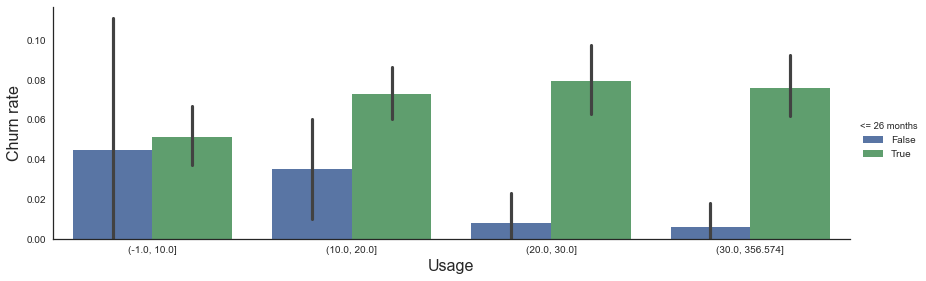

In [46]:
# Subscriptions are renewed monthly and thus the number of transactions is used as a proxy for time
temp_subset['<= 26 months'] = temp_subset['transaction_num'] <= 26.5
temp_subset['Playlist_usage_bin'] = pd.cut(temp_subset.Playlist_usage,bins=[-1,10,20,30,temp_subset.Playlist_usage.max()], right=True)
sns.factorplot(x='Playlist_usage_bin', y='is_churn',hue='<= 26 months', data=temp_subset, kind='bar', aspect=3)
plt.ylabel('Churn rate', fontsize=16)
plt.xlabel('Usage', fontsize=16)

__Managerial Insight:__  Retention efforts need to be made on all customers that have been with the service for less than 2 years regardless of actual usage.

* Usage was derived from customer listening habits of songs, where the song listened to was at least 75% complete.

### Insight 2

A large drop in passive usage is a significantly more telling of churn than a large drop in active listening.

* Passive listening is based on songs listened to completion
* Active listening is based on songs not listened to completion
* All active category charts are in the code section, only the sub 25% usage is shown in this section, but they are similar.

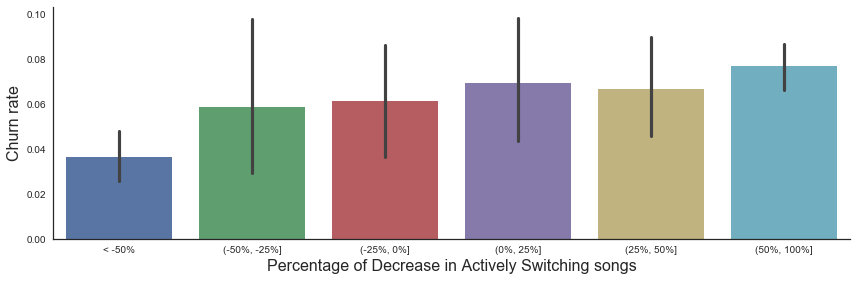

In [49]:
temp_subset['Active_percentage_drop'] = pd.cut(temp_subset.num_25,bins=[-inf,-0.5,-0.25,0,0.25,0.5,1], right=True, 
                                              labels = ['< -50%', '(-50%, -25%]', '(-25%, 0%]', '(0%, 25%]', '(25%, 50%]', '(50%, 100%]'])
sns.factorplot(x='Active_percentage_drop', y='is_churn', data=temp_subset, kind='bar',aspect=3)
plt.ylabel('Churn rate', fontsize=16)
plt.xlabel('Percentage of Decrease in Actively Switching songs', fontsize=16)

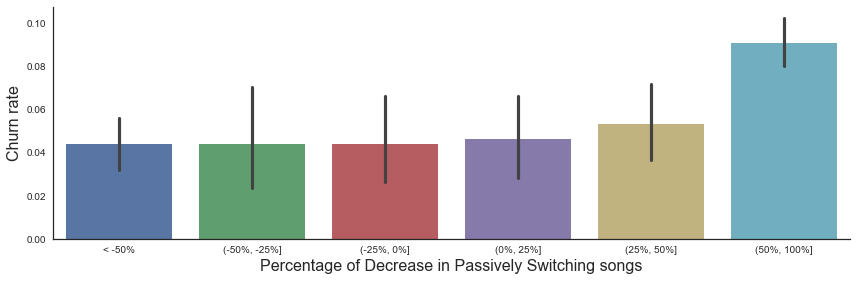

In [50]:
temp_subset['Passive_percentage_drop'] = pd.cut(temp_subset.num_100,bins=[-inf,-0.5,-0.25,0,0.25,0.5,1], right=True,
                                               labels = ['< -50%', '(-50%, -25%]', '(-25%, 0%]', '(0%, 25%]', '(25%, 50%]', '(50%, 100%]'])
sns.factorplot(x='Passive_percentage_drop', y='is_churn', data=temp_subset, kind='bar',aspect=3)
plt.ylabel('Churn rate', fontsize=16)
plt.xlabel('Percentage of Decrease in Passively Switching songs', fontsize=16)

__Managerial Insight:__  In terms of behavior to monitor we want to pay attention to customers that that drop their passive listening habits by over 50%.  Retention efforts should be made on customers showing this drop.

### Insight 3

Young users are significantly more likely to leave the service.

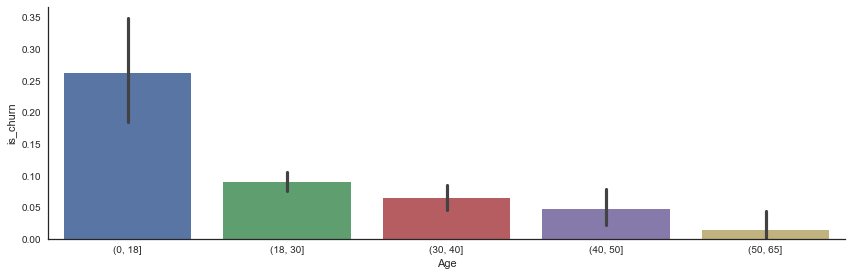

In [50]:
sns.factorplot(x='Age', y='is_churn', data=temp_subset, kind='bar', aspect=3)

__Managerial Insight:__  Special marketing efforts need to be made towards younger customers to keep them as subsribers.

## Summary

Customer rentention should focus on young customers, customers that significantly drop their passively listening habits, and customers that have been with the service under two years.

End business report

In [1]:
# print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline

import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus
import matplotlib.pyplot as plt
from string import ascii_letters

Populating the interactive namespace from numpy and matplotlib


# Create data subset

#### The given files on kaggle are too large to build a model on a PC.  Therefore, the plan is to take a subset of training data to build the code and then will run the code on the full dataset in the cloud.

In [133]:
df1 = pd.read_csv('members.csv')  # kkbox member dataset

In [134]:
df2 = pd.read_csv('train.csv')  # kkbox training dataset

In [135]:
build = df2[::175]  # Grabbing subset of training dataset

In [136]:
len(build)

5674

In [ ]:
# Merge the member dataset into training subset dataset
build = build.merge(df1, left_on='msno', right_on='msno', how='left') 
# Drop double index
build = build.dropna(subset=['Unnamed: 0']) 

In [ ]:
# Verifying that there is enough users that churn
build.is_churn.sum()

In [ ]:
# Create the new member dataset file that includes training data
build.to_csv('build_members.csv')

In [80]:
df3 = pd.read_csv('transactions.csv')  # kkbox transaction dataset

In [ ]:
# Merge the member list into the transaction dataset.  
build2 = df3.merge(build, left_on='msno', right_on='msno', how='left')
# For the items that don't have a merge, column expiration_date will be NaN and are removed
build3 = build2.dropna(subset=['expiration_date'])

In [ ]:
len(build3)

In [ ]:
# Save the new transactions data
build3.to_csv('build_transactions.csv') 

In [ ]:
df4 = pd.read_csv('build_members.csv')

In [4]:
# Since the data is too large, we will take the large file in sections.  
# We build the same way that we do the transaction data.  
chunksize = 10 ** 7
n=0
for chunk in pd.read_csv('user_logs.csv', chunksize = chunksize):
    build4 = chunk.merge(build, left_on='msno', right_on='msno', how='left')
    build5 = build4.dropna(subset=['is_churn'])
    n=n+1
    name = str(n) + '.csv'
    build5.to_csv(name)

In [17]:
# The chunk method left us with numerous files that we now need to combine into one file
build6 = pd.read_csv('1.csv')
for i in range(39):
    name = str(i+1) + '.csv'
    build6 = build6.append(pd.read_csv(name))

In [18]:
len(build6)

1459582

In [19]:
# Export our last build file.
build6.to_csv('build_user_logs.csv')

# Data Cleaning

#### Load created files

* Submitted files start here

In [2]:
members = pd.read_csv('build_members.csv')
transactions = pd.read_csv('build_transactions.csv')
user_logs = pd.read_csv('build_user_logs.csv')

In [3]:
len(members)
len(transactions)
len(user_logs)

5674

83214

1459582

## Members

#### Set dates variables

In [4]:
members['registration_init_time'] = pd.to_datetime(members['registration_init_time'], format = '%Y%m%d')
members['expiration_date'] = pd.to_datetime(members['expiration_date'], format = '%Y%m%d')

## Transactions

#### Add the latest data from transactions list
Take the last value of is_auto_renew, is_cancel, membership_expire_date, 

In [5]:
# temporary dataframe of last transaction
df = transactions.groupby('msno').apply(lambda x : x[x['transaction_date'] == x['transaction_date'].max()].iloc[0,:])
# drop unneeded column
df.drop(['Unnamed: 0','is_churn','city','bd','gender','registered_via','registration_init_time','expiration_date'], axis = 1, inplace = True)  
# merge member data with latest transaction data
temp_subset = members.merge(df,  left_on='msno', right_on='msno', how='left') 
# remove unneeded columns
temp_subset.drop(['Unnamed: 0'],axis = 1, inplace = True) 

#### Set date variables

In [6]:
temp_subset['transaction_date'] = pd.to_datetime(temp_subset['transaction_date'], format = '%Y%m%d')
temp_subset['membership_expire_date'] = pd.to_datetime(temp_subset['membership_expire_date'], format = '%Y%m%d')

#### Add number of total transactions, different payment methods, and different length of membership plan in the past

In [7]:
# number of total transactions for member
transaction_num = pd.DataFrame(transactions.groupby('msno').is_churn.count()).reset_index().rename(columns= {'is_churn':'transaction_num'})
temp_subset = temp_subset.merge(transaction_num, left_on='msno', right_on='msno')
# number of different payment methods used for member
payment_num_unique = pd.DataFrame(transactions.groupby('msno').payment_method_id.nunique()).reset_index().rename(columns= {'payment_method_id':'payment_nunique'})
temp_subset = temp_subset.merge(payment_num_unique, left_on='msno', right_on='msno')
# number of different payment plans days used for member
plans_num_unique = pd.DataFrame(transactions.groupby('msno').payment_plan_days.nunique()).reset_index().rename(columns= {'payment_plan_days':'plans_nunique'})
temp_subset = temp_subset.merge(plans_num_unique, left_on='msno', right_on='msno')

#### Set Category Variables

In [8]:
temp_subset = pd.get_dummies(temp_subset,columns=['city'])
temp_subset = pd.get_dummies(temp_subset,columns=['gender'])

## User logs

#### Create user_history as the target converted dataset

In [9]:
df5 = user_logs.copy()

In [10]:
user_history = df5.groupby('msno').agg({'total_secs':['size','std','mean'], 'num_unq':['sum','mean']}).reset_index()

In [11]:
user_history.columns=['msno','num_of_record','std_sec','average_sec','total_unq_songs','average_song']

#### Add average_repeat_song

In [12]:
df5['Repeat_songs'] = df5.num_100 - df5.num_unq

In [13]:
average_repeat_song = pd.DataFrame(df5.groupby('msno')['Repeat_songs'].mean()).reset_index()

In [14]:
user_history = user_history.merge(average_repeat_song, how='left', on='msno')

#### Add Quick scan behavior

In [15]:
average_quick_scan = pd.DataFrame(df5.groupby('msno')['num_25'].mean()).reset_index().rename(columns= {'num_25':'Quick_scan'})

In [16]:
user_history = user_history.merge(average_quick_scan, how='left', on='msno')

#### Add Playlist usage

In [17]:
df5['Playlist_usage'] = df5.num_985 + df5.num_100

In [18]:
average_playlist_usage = pd.DataFrame(df5.groupby('msno')['Playlist_usage'].mean()).reset_index()

In [19]:
user_history = user_history.merge(average_playlist_usage, how='left', on='msno')

In [20]:
#merge into temp_subset
temp_subset = temp_subset.merge(user_history,  left_on='msno', right_on='msno', how='left')

#### Remove extra columns

In [21]:
user_logs.drop(['Unnamed: 0', 'Unnamed: 0.1', 'is_churn'], axis=1, inplace=True)

#### (Get average - last entry) / average
How user behavior in the last entry shift from his/her own average history

 1 means the user stop listening to all music for that column </p>
-1 means the user doubled his listening

In [22]:
df6 = user_logs.groupby('msno').mean()
df6.drop(['date'], axis=1, inplace=True)
df7 = user_logs.groupby('msno').apply(lambda x : x[x['date'] == x['date'].max()])
df7.drop(['msno'], axis=1, inplace=True)
df8 = (df6 - df7) / df6  # +1 = 100% loss, -1 100% = gain, 0 = stays the same
df8 = df8.reset_index()
df8.drop(['level_1', 'date'], axis=1, inplace=True)

#### Replace nan values with 0

In [23]:
df8.fillna(0, inplace=True)

#### Convert varaibles to float32

In [24]:
df8['num_100'] = float32(df8['num_100'])
df8['num_25'] = float32(df8['num_25'])
df8['num_50'] = float32(df8['num_50'])
df8['num_75'] = float32(df8['num_75'])
df8['num_985'] = float32(df8['num_985'])
df8['num_unq'] = float32(df8['num_unq'])
df8['total_secs'] = float32(df8['total_secs'])

In [25]:
#merge into temp_subset
temp_subset = temp_subset.merge(df8,  left_on='msno', right_on='msno', how='left')

# Checkpoint

## Correlation

In [26]:
c = temp_subset.corr().abs()
s = c.unstack().sort_values(ascending = False)

In [27]:
s = s[s!=1]

In [28]:
s

actual_amount_paid  plan_list_price       0.999104
plan_list_price     actual_amount_paid    0.999104
payment_plan_days   plan_list_price       0.974220
plan_list_price     payment_plan_days     0.974220
actual_amount_paid  payment_plan_days     0.973607
payment_plan_days   actual_amount_paid    0.973607
num_100             total_secs            0.950271
total_secs          num_100               0.950271
average_sec         std_sec               0.835722
std_sec             average_sec           0.835722
total_secs          num_unq               0.820335
num_unq             total_secs            0.820335
Playlist_usage      average_song          0.804262
average_song        Playlist_usage        0.804262
num_100             num_unq               0.784382
num_unq             num_100               0.784382
average_song        total_unq_songs       0.761979
total_unq_songs     average_song          0.761979
num_of_record       total_unq_songs       0.751898
total_unq_songs     num_of_reco

In [32]:
temp_subset.columns

Index([u'msno', u'is_churn', u'bd', u'registered_via',
       u'registration_init_time', u'expiration_date', u'Taipei',
       u'payment_method_id', u'payment_plan_days', u'plan_list_price',
       u'actual_amount_paid', u'is_auto_renew', u'transaction_date',
       u'membership_expire_date', u'is_cancel', u'transaction_num',
       u'payment_nunique', u'plans_nunique', u'city_1.0', u'city_3.0',
       u'city_4.0', u'city_5.0', u'city_6.0', u'city_7.0', u'city_8.0',
       u'city_9.0', u'city_10.0', u'city_11.0', u'city_12.0', u'city_13.0',
       u'city_14.0', u'city_15.0', u'city_16.0', u'city_17.0', u'city_18.0',
       u'city_20.0', u'city_21.0', u'city_22.0', u'gender_female',
       u'gender_male', u'num_of_record', u'std_sec', u'average_sec',
       u'total_unq_songs', u'average_song', u'Repeat_songs', u'Quick_scan',
       u'Playlist_usage', u'num_100', u'num_25', u'num_50', u'num_75',
       u'num_985', u'num_unq', u'total_secs'],
      dtype='object')

In [29]:
temp2 = temp_subset.drop(['plan_list_price', 'total_unq_songs','actual_amount_paid', 'payment_method_id','total_secs','num_unq','registered_via','std_sec','average_song'], axis=1)

In [30]:
c = temp2.corr().abs()
s = c.unstack().sort_values(ascending = False)

In [31]:
s = s[s!=1]
s

Repeat_songs     Playlist_usage     0.616473
Playlist_usage   Repeat_songs       0.616473
city_1.0         bd                 0.613260
bd               city_1.0           0.613260
transaction_num  num_of_record      0.561358
num_of_record    transaction_num    0.561358
is_cancel        is_churn           0.532810
is_churn         is_cancel          0.532810
city_1.0         gender_male        0.529841
gender_male      city_1.0           0.529841
num_50           num_25             0.503194
num_25           num_50             0.503194
plans_nunique    num_of_record      0.500776
num_of_record    plans_nunique      0.500776
gender_female    city_1.0           0.500031
city_1.0         gender_female      0.500031
plans_nunique    city_1.0           0.496070
city_1.0         plans_nunique      0.496070
num_50           num_75             0.482210
num_75           num_50             0.482210
transaction_num  plans_nunique      0.459125
plans_nunique    transaction_num    0.459125
Quick_scan

#### Correlation Matrix

In [32]:
corr = temp2.corr()

In [33]:
corr

,is_churn,bd,payment_plan_days,is_auto_renew,is_cancel,transaction_num,payment_nunique,plans_nunique,city_1.0,city_3.0,...,num_of_record,average_sec,Repeat_songs,Quick_scan,Playlist_usage,num_100,num_25,num_50,num_75,num_985
is_churn,1.000000,0.028426,0.252333,-0.370103,0.532810,-0.164928,0.125720,0.032533,-0.076498,0.009654,...,-0.041495,0.000580,-0.016925,0.039278,0.005675,0.078381,0.045628,0.026718,0.040056,0.034082
bd,0.028426,1.000000,0.049594,-0.066421,0.008381,0.107316,0.119144,0.325168,-0.613260,0.038319,...,0.240334,-0.022030,0.082392,-0.004527,0.150984,0.033756,0.012929,0.013659,0.014803,-0.000190
payment_plan_days,0.252333,0.049594,1.000000,-0.342218,-0.023985,-0.203714,0.044238,0.011536,-0.106411,0.017335,...,0.076182,0.006015,0.002164,0.021066,0.042792,0.021691,0.030892,0.010245,0.015510,-0.000669
is_auto_renew,-0.370103,-0.066421,-0.342218,1.000000,0.070088,0.300210,-0.276671,-0.037313,0.172581,-0.016821,...,-0.005425,0.004607,-0.003845,-0.107382,-0.086282,-0.023786,-0.021431,-0.010637,-0.019086,0.008428
is_cancel,0.532810,0.008381,-0.023985,0.070088,1.000000,0.013473,0.020179,0.013684,-0.009569,0.013127,...,-0.018355,-0.000813,-0.023812,0.028086,-0.013774,0.052021,0.021070,0.012687,0.022783,0.027585
transaction_num,-0.164928,0.107316,-0.203714,0.300210,0.013473,1.000000,-0.054679,0.459125,-0.132044,0.014506,...,0.561358,-0.037306,0.038607,-0.064981,0.052512,-0.012295,-0.025498,-0.035267,-0.028029,-0.001303
payment_nunique,0.125720,0.119144,0.044238,-0.276671,0.020179,-0.054679,1.000000,0.302096,-0.286189,0.025534,...,0.150190,-0.035995,0.005829,0.075463,0.110634,0.029446,0.037920,0.005777,0.016879,-0.006920
plans_nunique,0.032533,0.325168,0.011536,-0.037313,0.013684,0.459125,0.302096,1.000000,-0.496070,0.022545,...,0.500776,-0.046877,0.058718,-0.004039,0.141994,0.026858,0.007651,-0.020850,-0.007232,-0.007232
city_1.0,-0.076498,-0.613260,-0.106411,0.172581,-0.009569,-0.132044,-0.286189,-0.496070,1.000000,-0.077759,...,-0.392078,0.039964,-0.083324,-0.045082,-0.228706,-0.046501,-0.011564,0.002707,-0.016627,0.006969
city_3.0,0.009654,0.038319,0.017335,-0.016821,0.013127,0.014506,0.025534,0.022545,-0.077759,1.000000,...,0.024772,-0.006890,-0.010122,0.024321,0.010146,-0.002058,-0.023726,-0.028895,-0.026175,-0.028420


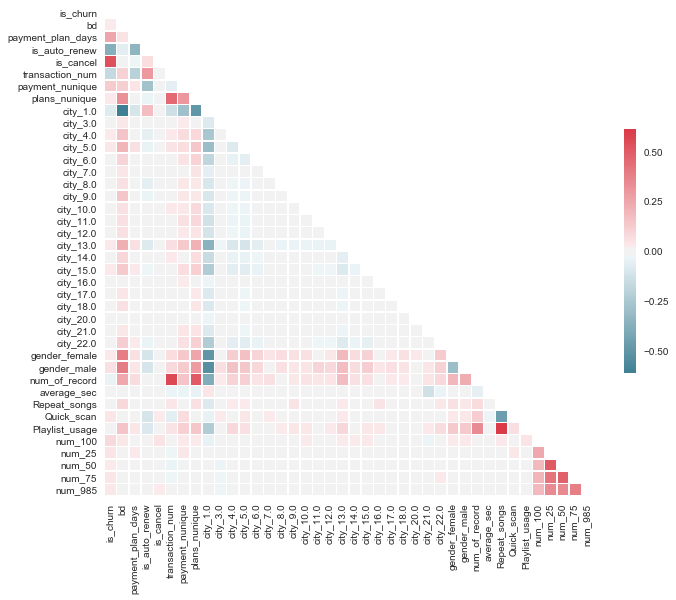

In [34]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Classification

In [35]:
temp_subsetnodates = temp2.drop(['registration_init_time','expiration_date','transaction_date','membership_expire_date'], axis=1)
temp_subsetnodates.fillna(0, inplace=True)

In [36]:
X = temp_subsetnodates.drop(['msno', 'is_churn'], axis=1)
Y = temp_subsetnodates.is_churn

## Decision Tree

In [37]:
dt = tree.DecisionTreeClassifier(max_depth=3)
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

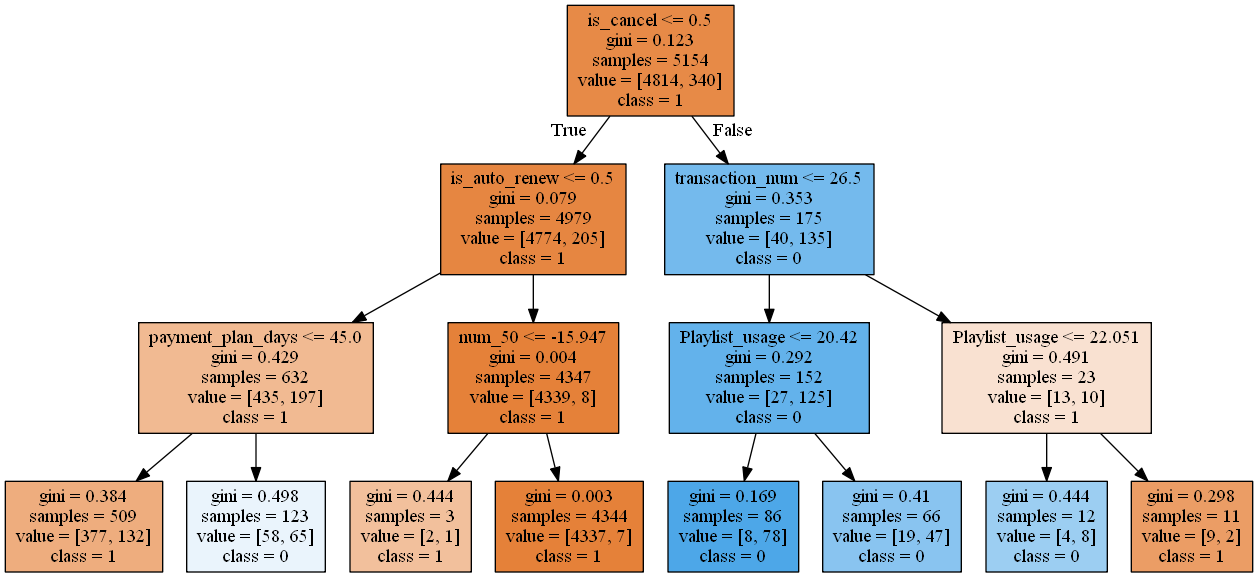

In [38]:
# This code will visualize a decision tree dt, trained with the attributes in X and the class labels in Y
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

## Clustering

In [39]:
from sklearn.cluster import KMeans

In [40]:
temp_cluster = temp_subsetnodates.drop(['msno'], axis=1)

In [41]:
clu = KMeans(n_clusters=4, random_state=0)
clu.fit(temp_cluster)
temp_cluster['cluster'] = clu.labels_
temp_cluster.groupby('cluster').mean()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

,is_churn,bd,payment_plan_days,is_auto_renew,is_cancel,transaction_num,payment_nunique,plans_nunique,city_1.0,city_3.0,...,num_of_record,average_sec,Repeat_songs,Quick_scan,Playlist_usage,num_100,num_25,num_50,num_75,num_985
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.065971,13.887554,34.462781,0.878299,0.034069,16.488578,1.189445,1.609295,0.504332,0.005908,...,287.442103,-3.171427e+10,-0.297275,5.739023,25.288157,0.080062,0.100281,0.156877,0.162090,0.145520
1,0.000000,26.000000,30.000000,1.000000,0.000000,11.000000,2.000000,2.000000,0.000000,0.000000,...,16.000000,-5.764608e+14,-16.375000,15.875000,6.187500,-0.617977,0.811024,0.288889,1.000000,-0.600000
2,0.100000,19.500000,30.000000,0.800000,0.100000,22.100000,1.200000,2.000000,0.300000,0.000000,...,512.900000,-1.152813e+14,1.608149,6.381012,37.215421,0.147380,-0.264944,-0.412058,-0.096120,-0.786414
3,0.061538,21.969231,35.846154,0.815385,0.015385,22.984615,1.415385,2.307692,0.184615,0.015385,...,560.446154,-2.634341e+13,0.123718,7.341121,34.950634,0.200461,0.240683,0.349309,0.338005,0.285311


# Data Visualization

#### Customers that listen to more songs are more likely to leave the service given that they have been a customer for less than 2 years.

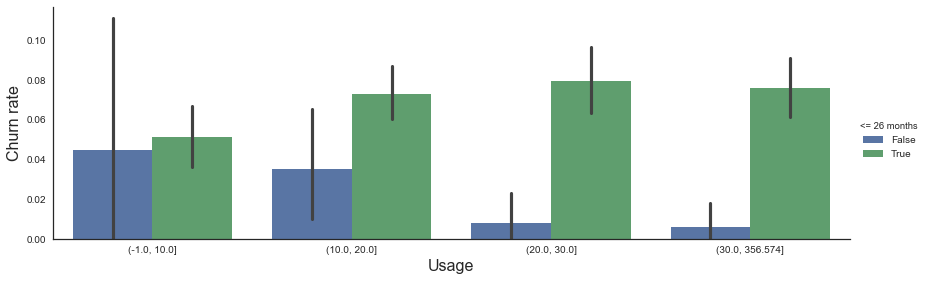

In [48]:
# Subscriptions are renewed monthly and thus the number of transactions is used as a proxy for time
temp_subset['<= 26 months'] = temp_subset['transaction_num'] <= 26.5
temp_subset['Playlist_usage_bin'] = pd.cut(temp_subset.Playlist_usage,bins=[-1,10,20,30,temp_subset.Playlist_usage.max()], right=True)
sns.factorplot(x='Playlist_usage_bin', y='is_churn',hue='<= 26 months', data=temp_subset, kind='bar', aspect=3)
plt.ylabel('Churn rate', fontsize=16)
plt.xlabel('Usage', fontsize=16)

#### Customers who change songs more actively are less likely to churn than those who put music in the background and change passively.

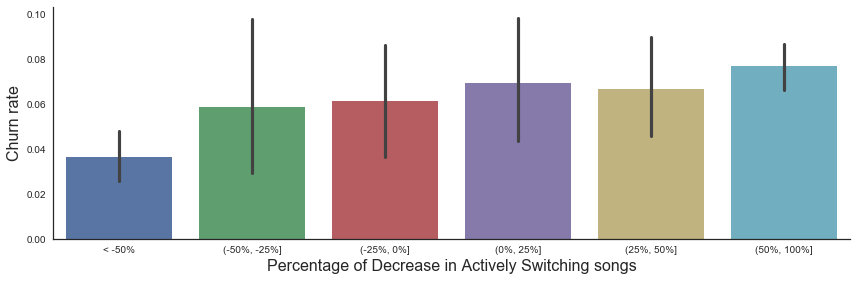

In [49]:
temp_subset['Active_percentage_drop'] = pd.cut(temp_subset.num_25,bins=[-inf,-0.5,-0.25,0,0.25,0.5,1], right=True, 
                                              labels = ['< -50%', '(-50%, -25%]', '(-25%, 0%]', '(0%, 25%]', '(25%, 50%]', '(50%, 100%]'])
sns.factorplot(x='Active_percentage_drop', y='is_churn', data=temp_subset, kind='bar',aspect=3)
plt.ylabel('Churn rate', fontsize=16)
plt.xlabel('Percentage of Decrease in Actively Switching songs', fontsize=16)

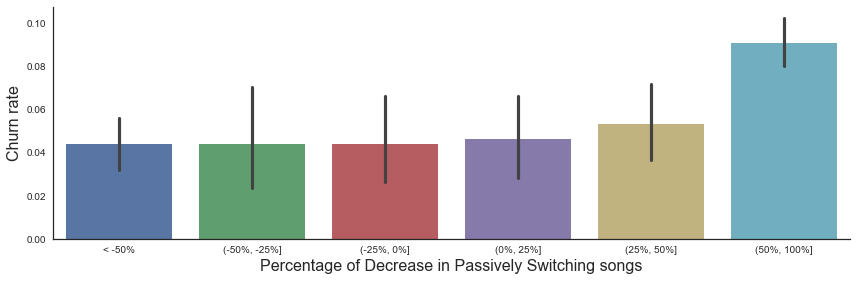

In [50]:
temp_subset['Passive_percentage_drop'] = pd.cut(temp_subset.num_100,bins=[-inf,-0.5,-0.25,0,0.25,0.5,1], right=True,
                                               labels = ['< -50%', '(-50%, -25%]', '(-25%, 0%]', '(0%, 25%]', '(25%, 50%]', '(50%, 100%]'])
sns.factorplot(x='Passive_percentage_drop', y='is_churn', data=temp_subset, kind='bar',aspect=3)
plt.ylabel('Churn rate', fontsize=16)
plt.xlabel('Percentage of Decrease in Passively Switching songs', fontsize=16)

#### Students under 18 has a high churn rate.  Maybe KKbox should consider having a student plan like Amazon student Prime.

In [49]:
temp_subset['Age'] = pd.cut(temp_subset.bd,bins=[0,18,30,40,50,65], right=True)

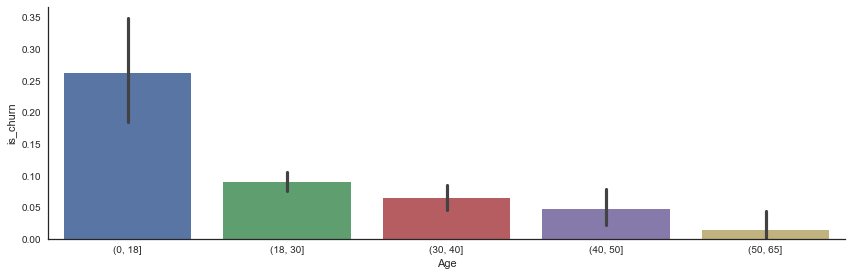

In [50]:
sns.factorplot(x='Age', y='is_churn', data=temp_subset, kind='bar', aspect=3)

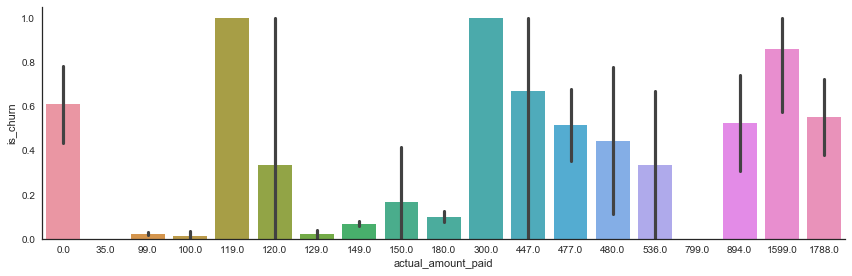

In [51]:
sns.factorplot(x='actual_amount_paid', y='is_churn', data=temp_subset, kind='bar', aspect=3)

In [52]:
temp_subset.columns

Index([u'msno', u'is_churn', u'bd', u'registered_via',
       u'registration_init_time', u'expiration_date', u'Taipei',
       u'payment_method_id', u'payment_plan_days', u'plan_list_price',
       u'actual_amount_paid', u'is_auto_renew', u'transaction_date',
       u'membership_expire_date', u'is_cancel', u'transaction_num',
       u'payment_nunique', u'plans_nunique', u'city_1.0', u'city_3.0',
       u'city_4.0', u'city_5.0', u'city_6.0', u'city_7.0', u'city_8.0',
       u'city_9.0', u'city_10.0', u'city_11.0', u'city_12.0', u'city_13.0',
       u'city_14.0', u'city_15.0', u'city_16.0', u'city_17.0', u'city_18.0',
       u'city_20.0', u'city_21.0', u'city_22.0', u'gender_female',
       u'gender_male', u'num_of_record', u'std_sec', u'average_sec',
       u'total_unq_songs', u'average_song', u'Repeat_songs', u'Quick_scan',
       u'Playlist_usage', u'num_100', u'num_25', u'num_50', u'num_75',
       u'num_985', u'num_unq', u'total_secs', u'Transaction record <= 2 years',
       u'Play

In [53]:
gr = temp_subset.groupby(['Taipei','is_churn'])['average_sec'].mean()

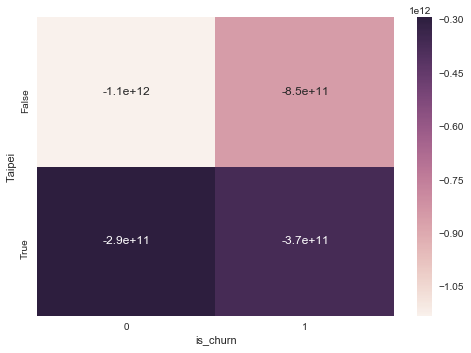

In [54]:
sns.heatmap(gr.unstack(), annot=True)

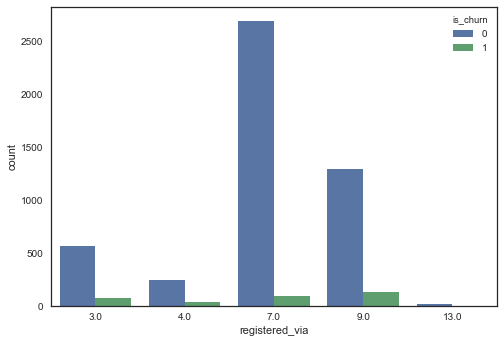

In [55]:
sns.countplot(x='registered_via',hue='is_churn',data=temp_subset)

# Machine Learning Model

## Holdout Sample

Split the data into 70% training and 30% test

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.3, random_state = 0)

## Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier
cl = RandomForestClassifier(random_state=0)
cl.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### Feature Importance

                   importance
feature                      
is_cancel               0.246
is_auto_renew           0.131
Quick_scan              0.058
Repeat_songs            0.054
transaction_num         0.050
average_sec             0.049
num_100                 0.047
num_of_record           0.045
payment_plan_days       0.044
Playlist_usage          0.044
bd                      0.034
num_25                  0.032
num_50                  0.029
num_985                 0.026
num_75                  0.021
payment_nunique         0.016
plans_nunique           0.016
gender_female           0.009
city_1.0                0.007
city_15.0               0.006
gender_male             0.005
city_13.0               0.004
Taipei                  0.004
city_4.0                0.004
city_5.0                0.004
city_22.0               0.002
city_6.0                0.002
city_14.0               0.002
city_21.0               0.002
city_18.0               0.001
city_3.0                0.001
city_12.0 

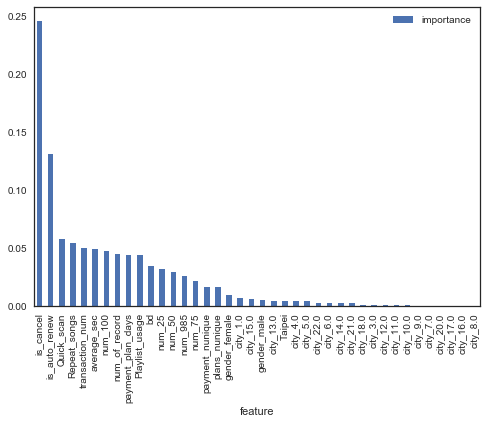

In [58]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(cl.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
print importances
importances.plot.bar()

In [59]:
y_pred = cl.predict(X_test)
y_pred_proba = cl.predict_proba(X_test)[:,1]

#### Confusion Matrix

In [60]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred, Y_test)

array([[1423,   57],
       [  26,   41]])

#### Accuracy

In [61]:
(y_pred == Y_test).mean()

0.94634776987718161

#### Precision

In [62]:
import sklearn.metrics as met

In [63]:
met.precision_score(Y_test,y_pred)

0.61194029850746268

In [64]:
Y_test.mean()

0.063348416289592757

#### Recall

In [65]:
met.recall_score(Y_test,y_pred)

0.41836734693877553

#### AUC score

In [66]:
met.roc_auc_score(Y_test,y_pred_proba)

0.94673314460359714

(0, 1)

(0, 1)

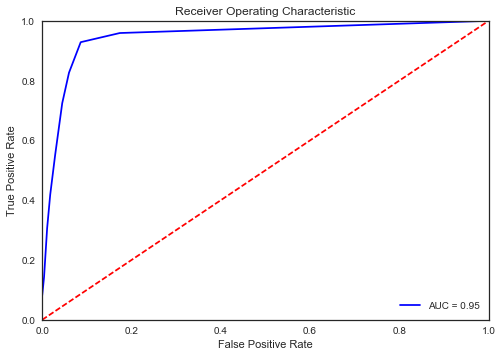

In [67]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = met.roc_curve(Y_test, y_pred_proba)
roc_auc = met.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Cross-validation

In [68]:
nfolds = 10

In [69]:
from sklearn.model_selection import KFold

In [70]:
kf = KFold(n_splits=nfolds,random_state=0,shuffle=True)

In [71]:
avgCV_AUC = sk.model_selection.cross_val_score(cl,X,Y,cv=kf,n_jobs=-1,scoring='roc_auc').mean()

In [72]:
avgCV_AUC

0.94777192941115351

# Finding the best Classifier

A list of Classifiers

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

clfs = [DecisionTreeClassifier(), sk.ensemble.RandomForestClassifier(n_jobs=-1), sk.naive_bayes.GaussianNB(),
        sk.linear_model.LogisticRegression(n_jobs=-1),sk.tree.DecisionTreeClassifier(),sk.ensemble.AdaBoostClassifier(),
        QuadraticDiscriminantAnalysis(),MLPClassifier(),SVC()]

In [74]:
maxAUC = -1
bestCL = ""
for cl in clfs:
    auc = sk.model_selection.cross_val_score(cl,X,Y,cv=kf,n_jobs=-1,scoring='roc_auc').mean()
    print (str(cl) + ' ' + str(auc))
    if auc > maxAUC:
        bestCL = cl
        maxAUC = auc
print ('Best is... ' + str(bestCL) + ' ' + str(maxAUC))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 0.765226882279
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 0.939935653971
GaussianNB(priors=None) 0.495623827971


/Users/shaotangchien/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/Users/shaotangchien/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/Users/shaotangchien/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/Users/shaotangchien/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'.

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 0.517778758805
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 0.765226882279
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None) 0.951152176592
QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001) 0.828617169422
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto',

From the above, we can derive the conclusion that AdaBoostClassifer has the best performance among all the classifers, which returns average AUC as 0.953.